In [340]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from ast import literal_eval
from collections import Counter
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
%matplotlib inline

# Predicting Movie Revenue (Part 1: Cost-effectiveness of Actors to Film Incomen)
### DS 5110 - Group 6

**Introduction.** In today's fast-paced social life, more and more people will go to the cinema to watch movies to relax themselves. According to statistics, thousands of movies are released every year around the world, and the average production cycle of each movie takes more than two years. Therefore, whether each film can be profitable after its release is the most concerned issue of every film producer.

The main purpose of our project is to use the information in the existing movie database to mine the relationship between movie gross and other variables. We believe that the most judging indicator of a film's success in the film industry is its commercial value, so our project will predict what factors will affect the commercial value of a movie and how to maximize it.

**Problem Definition.** Famous actors in a film production will have high appearance fees but will attract the audience to
watch and thus increase the movie gross. However, not the more famous actors hired, the higher
revenue will be. This problem will examine the direct relationship between the number of famous
actors and the movie revenues and will also predict how many famous actors should be hired to
maximize movie gross.

## 1. Data Preprocessing

The dataset is provided by MovieLens on Kaggle. It consists of movies released on or before July 2017. We need movie cast, movie budget, movie revenue, etc. to analyze and predict the problem.



The data of movie casts are stored in a list of one column of the csv file, which contains the names of all casts, the roles played, gender, photos and the id of the movie to which they belong. We first need to extract the actor name and movie id we need

In [341]:
df_credits = pd.read_csv("data/credits.csv")

In [342]:
df_credits['cast'] = df_credits['cast'].apply(literal_eval)

Extract the actor name and movie id

In [343]:
def get_name_castId(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        cast_ids = [i['id'] for i in x]
        return [names, cast_ids]
    return []

In [344]:
cast = df_credits['cast']
cast = cast.apply(get_name_castId)
ids = list(df_credits['id'])
for i in range(len(cast)):
    cast[i].append(ids[i])
cast[0]

[['Tom Hanks',
  'Tim Allen',
  'Don Rickles',
  'Jim Varney',
  'Wallace Shawn',
  'John Ratzenberger',
  'Annie Potts',
  'John Morris',
  'Erik von Detten',
  'Laurie Metcalf',
  'R. Lee Ermey',
  'Sarah Freeman',
  'Penn Jillette'],
 [31,
  12898,
  7167,
  12899,
  12900,
  7907,
  8873,
  1116442,
  12901,
  12133,
  8655,
  12903,
  37221],
 862]

In [345]:
df = pd.DataFrame()
for x in cast:
    diction = {'cast_name': x[0], 'cast_id': x[1],'movie_id': x[2]}
    df = df.append(diction, ignore_index=True)
df.head()

,cast_name,cast_id,movie_id
0,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...","[31, 12898, 7167, 12899, 12900, 7907, 8873, 11...",862
1,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...","[2157, 8537, 205, 145151, 5149, 10739, 58563, ...",8844
2,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...","[6837, 3151, 13567, 16757, 589, 16523, 7166]",15602
3,"[Whitney Houston, Angela Bassett, Loretta Devi...","[8851, 9780, 18284, 51359, 66804, 352, 87118, ...",31357
4,"[Steve Martin, Diane Keaton, Martin Short, Kim...","[67773, 3092, 519, 70696, 59222, 18793, 14592,...",11862


In [346]:
df_movie = pd.read_csv("data/movies_metadata.csv")

In [347]:
df_movie = df_movie[["budget","genres","title","revenue","id"]]
df_movie.head()

,budget,genres,title,revenue,id
0,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",Toy Story,373554033.0,862
1,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",Jumanji,262797249.0,8844
2,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",Grumpier Old Men,0.0,15602
3,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",Waiting to Exhale,81452156.0,31357
4,0,"[{'id': 35, 'name': 'Comedy'}]",Father of the Bride Part II,76578911.0,11862


In [348]:
literal_eval(df_movie.genres.values[0])

[{'id': 16, 'name': 'Animation'},
 {'id': 35, 'name': 'Comedy'},
 {'id': 10751, 'name': 'Family'}]

In [349]:
uniqueGenres = set([])
for i in df_movie.genres.values: # I am looping through all the rows
    genList = literal_eval(i) # convert from string to list of dict
    for j in genList: # loop through the list of dict
        uniqueGenres.add(j["name"]) # add the name of the genre to my uniqueGenres variabe
uniqueGenres

{'Action',
 'Adventure',
 'Animation',
 'Aniplex',
 'BROSTA TV',
 'Carousel Productions',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Foreign',
 'GoHands',
 'History',
 'Horror',
 'Mardock Scramble Production Committee',
 'Music',
 'Mystery',
 'Odyssey Media',
 'Pulser Productions',
 'Rogue State',
 'Romance',
 'Science Fiction',
 'Sentai Filmworks',
 'TV Movie',
 'Telescene Film Group Productions',
 'The Cartel',
 'Thriller',
 'Vision View Entertainment',
 'War',
 'Western'}

In [350]:
rows = [] # for all the movies
genres = list(uniqueGenres) # all unique Genres

for i in df_movie.genres: #looping through all the rows/movies
    genList = literal_eval(i) #converting from string to list of dict for a particular movie
    movieGenres = [x['name'] for x in genList] # list of all the genres of the movie
    row = [] # store a list of 1s and 0s for one movie
    for j in genres: #loop through all unique genres
        row.append(int(j in movieGenres)) #checking if the genre is present in that movie - if the genre is present 1 else 0
        rows.append(row)

In [351]:
genre = pd.DataFrame(rows,columns = genres)
genre

,Vision View Entertainment,The Cartel,TV Movie,Romance,Pulser Productions,Mardock Scramble Production Committee,Family,History,Music,Action,...,Carousel Productions,Thriller,BROSTA TV,Aniplex,Fantasy,Adventure,Western,Science Fiction,Sentai Filmworks,Odyssey Media
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454907,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1454908,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1454909,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1454910,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [352]:
df_movie = pd.concat([df_movie,genre], axis = 1) # joing the two dataframes
df_movie.shape, genre.shape

((1454912, 37), (1454912, 32))

In [353]:
df_movie = df_movie.drop(columns = ['genres'])

In [354]:
df_movie.head()

,budget,title,revenue,id,Vision View Entertainment,The Cartel,TV Movie,Romance,Pulser Productions,Mardock Scramble Production Committee,...,Carousel Productions,Thriller,BROSTA TV,Aniplex,Fantasy,Adventure,Western,Science Fiction,Sentai Filmworks,Odyssey Media
0,30000000,Toy Story,373554033.0,862,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,65000000,Jumanji,262797249.0,8844,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,Grumpier Old Men,0.0,15602,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,16000000,Waiting to Exhale,81452156.0,31357,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,Father of the Bride Part II,76578911.0,11862,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [355]:
df_movie["revenue"].isnull().sum()

1409452

In [356]:
df_movie = df_movie[df_movie['revenue'].notna()]
df_movie["revenue"].isnull().sum()

0

In [357]:
df_movie["revenue"][0]

373554033.0

In [358]:
sum(df_movie["revenue"] == 0)

38052

In [359]:
(sum(df_movie["revenue"] == 0)/df_movie.shape[0])*100

83.70435547734272

In [360]:
df_movie_revenue = df_movie
df_movie_revenue["revenue"] = df_movie_revenue["revenue"].replace(0, pd.np.nan)
df_movie_revenue["revenue"].isnull().sum()

38052

In [361]:
df_movie_revenue = df_movie_revenue[df_movie_revenue['revenue'].notna()]
df_movie_revenue["revenue"].isnull().sum()
df_movie_revenue["revenue"].describe()

count    7.408000e+03
mean     6.878739e+07
std      1.464203e+08
min      1.000000e+00
25%      2.400000e+06
50%      1.682272e+07
75%      6.722707e+07
max      2.787965e+09
Name: revenue, dtype: float64

In [362]:
df_movie_revenue["budget"] = df_movie_revenue["budget"].astype(int)
df_movie_revenue["budget"][0]

30000000

In [363]:
sum(df_movie_revenue["budget"] == 0)

2027

In [364]:
(sum(df_movie_revenue["budget"] == 0)/df_movie_revenue.shape[0])*100

27.36231101511879

In [365]:
df_movie_revenue_budget = df_movie_revenue
df_movie_revenue_budget["budget"] = df_movie_revenue_budget["budget"].replace(0, pd.np.nan)
df_movie_revenue_budget = df_movie_revenue_budget[df_movie_revenue_budget['budget'].notna()]
df_movie_revenue_budget["budget"].isnull().sum()
df_movie_revenue_budget["budget"].describe()

count    5.381000e+03
mean     3.109480e+07
std      4.016263e+07
min      1.000000e+00
25%      5.037000e+06
50%      1.700000e+07
75%      4.000000e+07
max      3.800000e+08
Name: budget, dtype: float64

In [366]:
df_movie_revenue_budget.head()

,budget,title,revenue,id,Vision View Entertainment,The Cartel,TV Movie,Romance,Pulser Productions,Mardock Scramble Production Committee,...,Carousel Productions,Thriller,BROSTA TV,Aniplex,Fantasy,Adventure,Western,Science Fiction,Sentai Filmworks,Odyssey Media
0,30000000.0,Toy Story,373554033.0,862,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,65000000.0,Jumanji,262797249.0,8844,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,16000000.0,Waiting to Exhale,81452156.0,31357,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,60000000.0,Heat,187436818.0,949,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,35000000.0,Sudden Death,64350171.0,9091,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [367]:
df_movie_revenue_budget.shape

(5381, 36)

In [368]:
df_movie_revenue_budget.rename(columns = {'id':'movie_id'}, inplace = True)
df_movie_revenue_budget["movie_id"].astype(str).astype(int).dtypes

dtype('int64')

In [369]:
df_movie_revenue_budget["movie_id"] = df_movie_revenue_budget["movie_id"].astype(str).astype(int)
df_movie_revenue_budget.dtypes

budget                                   float64
title                                     object
revenue                                  float64
movie_id                                   int64
Vision View Entertainment                  int64
The Cartel                                 int64
TV Movie                                   int64
Romance                                    int64
Pulser Productions                         int64
Mardock Scramble Production Committee      int64
Family                                     int64
History                                    int64
Music                                      int64
Action                                     int64
Crime                                      int64
Documentary                                int64
War                                        int64
Mystery                                    int64
Animation                                  int64
GoHands                                    int64
Horror              

In [370]:
df_movie_revenue_budget_cast = df_movie_revenue_budget.merge(df, on = "movie_id", how = 'left')
df_movie_revenue_budget_cast.shape

(5393, 38)

In [371]:
df_movie_revenue_budget_cast.head()

,budget,title,revenue,movie_id,Vision View Entertainment,The Cartel,TV Movie,Romance,Pulser Productions,Mardock Scramble Production Committee,...,BROSTA TV,Aniplex,Fantasy,Adventure,Western,Science Fiction,Sentai Filmworks,Odyssey Media,cast_name,cast_id
0,30000000.0,Toy Story,373554033.0,862,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...","[31, 12898, 7167, 12899, 12900, 7907, 8873, 11..."
1,65000000.0,Jumanji,262797249.0,8844,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...","[2157, 8537, 205, 145151, 5149, 10739, 58563, ..."
2,16000000.0,Waiting to Exhale,81452156.0,31357,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[Whitney Houston, Angela Bassett, Loretta Devi...","[8851, 9780, 18284, 51359, 66804, 352, 87118, ..."
3,60000000.0,Heat,187436818.0,949,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[Al Pacino, Robert De Niro, Val Kilmer, Jon Vo...","[1158, 380, 5576, 10127, 3197, 6200, 15851, 15..."
4,35000000.0,Sudden Death,64350171.0,9091,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[Jean-Claude Van Damme, Powers Boothe, Dorian ...","[15111, 6280, 8656, 10361, 12928, 79088]"


## 2. Data Analysis

In [372]:
all_actors = []
for name in df_movie_revenue_budget_cast.cast_name:
    all_actors.extend(name)

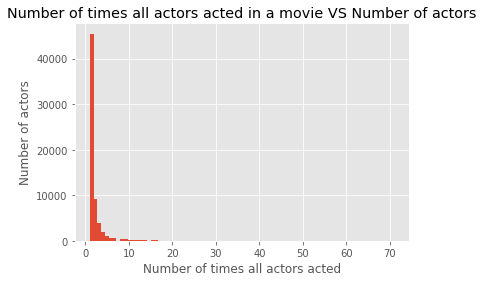

In [373]:
actors_fre = Counter(all_actors)
all_fre = list(actors_fre.values())
plt.hist(all_fre, bins = 80)
plt.title('Number of times all actors acted in a movie VS Number of actors')
plt.xlabel('Number of times all actors acted')
plt.ylabel('Number of actors')
plt.show()

In [374]:
all_fre.sort()
greater20 = 0
for i in range(len(all_fre)):
    if all_fre[i] > 20:
        greater20 = i
        break
all_fre = all_fre[greater5:]
len(all_fre)

333

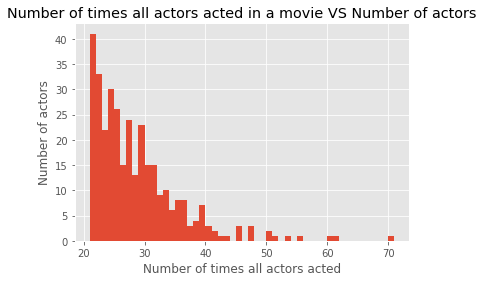

In [375]:
plt.hist(all_fre, bins = 50)
plt.title('Number of times all actors acted in a movie VS Number of actors')
plt.xlabel('Number of times all actors acted')
plt.ylabel('Number of actors')
plt.show()

In [376]:
print('From this, we can assume that the top 100 of actors in the number of movies are famous actors')
all_fre = list(actors_fre.values())
all_fre.sort()
all_fre = all_fre[-100:]
print('The number of top five percent actors is', len(all_fre))
print('The top 100 of actors have acted in at least {} films'.format(all_fre[0]))

From this, we can assume that the top 100 of actors in the number of movies are famous actors
The number of top five percent actors is 100
The top 100 of actors have acted in at least 30 films


In [377]:
famous_actors = set()
for actor in actors_fre:
    if actors_fre[actor] >= 30:
        famous_actors.add(actor)

In [378]:
famous_actors_df = []
famous_actors_num_df = []
for names in df_movie_revenue_budget_cast.cast_name:
    temp = []
    n = 0
    for name in names:
        if name in famous_actors:
            temp.append(name)
            n += 1
    famous_actors_df.append(temp)
    famous_actors_num_df.append(n)

In [379]:
df_movie_revenue_budget_cast['famous_actors']= famous_actors_df
df_movie_revenue_budget_cast['num_famous_actors']= famous_actors_num_df

In [380]:
df_movie_revenue_budget_cast.head(5)

,budget,title,revenue,movie_id,Vision View Entertainment,The Cartel,TV Movie,Romance,Pulser Productions,Mardock Scramble Production Committee,...,Fantasy,Adventure,Western,Science Fiction,Sentai Filmworks,Odyssey Media,cast_name,cast_id,famous_actors,num_famous_actors
0,30000000.0,Toy Story,373554033.0,862,0,0,0,0,0,0,...,0,0,0,0,0,0,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...","[31, 12898, 7167, 12899, 12900, 7907, 8873, 11...",[Tom Hanks],1
1,65000000.0,Jumanji,262797249.0,8844,0,0,0,0,0,0,...,0,0,0,0,0,0,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...","[2157, 8537, 205, 145151, 5149, 10739, 58563, ...","[Robin Williams, Kirsten Dunst]",2
2,16000000.0,Waiting to Exhale,81452156.0,31357,0,0,0,0,0,0,...,0,0,0,0,0,0,"[Whitney Houston, Angela Bassett, Loretta Devi...","[8851, 9780, 18284, 51359, 66804, 352, 87118, ...",[],0
3,60000000.0,Heat,187436818.0,949,0,0,0,0,0,0,...,0,0,0,0,0,0,"[Al Pacino, Robert De Niro, Val Kilmer, Jon Vo...","[1158, 380, 5576, 10127, 3197, 6200, 15851, 15...","[Robert De Niro, Danny Trejo, Philip Ettington]",3
4,35000000.0,Sudden Death,64350171.0,9091,0,0,0,0,0,0,...,0,0,0,0,0,0,"[Jean-Claude Van Damme, Powers Boothe, Dorian ...","[15111, 6280, 8656, 10361, 12928, 79088]",[],0


In [381]:
cond = df_movie_revenue_budget_cast.num_famous_actors > 0
df_movie_revenue_budget_cast = df_movie_revenue_budget_cast[cond]

In [382]:
df_movie_revenue_budget_cast.shape

(2375, 40)

In [383]:
df_movie_revenue_budget_cast['profit'] = df_movie_revenue_budget_cast.revenue - df_movie_revenue_budget_cast.budget

In [384]:
df_movie_revenue_budget_cast.head(5)

,budget,title,revenue,movie_id,Vision View Entertainment,The Cartel,TV Movie,Romance,Pulser Productions,Mardock Scramble Production Committee,...,Adventure,Western,Science Fiction,Sentai Filmworks,Odyssey Media,cast_name,cast_id,famous_actors,num_famous_actors,profit
0,30000000.0,Toy Story,373554033.0,862,0,0,0,0,0,0,...,0,0,0,0,0,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...","[31, 12898, 7167, 12899, 12900, 7907, 8873, 11...",[Tom Hanks],1,343554033.0
1,65000000.0,Jumanji,262797249.0,8844,0,0,0,0,0,0,...,0,0,0,0,0,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...","[2157, 8537, 205, 145151, 5149, 10739, 58563, ...","[Robin Williams, Kirsten Dunst]",2,197797249.0
3,60000000.0,Heat,187436818.0,949,0,0,0,0,0,0,...,0,0,0,0,0,"[Al Pacino, Robert De Niro, Val Kilmer, Jon Vo...","[1158, 380, 5576, 10127, 3197, 6200, 15851, 15...","[Robert De Niro, Danny Trejo, Philip Ettington]",3,127436818.0
7,44000000.0,Nixon,13681765.0,10858,0,0,0,0,0,0,...,0,0,0,0,0,"[Anthony Hopkins, Joan Allen, Powers Boothe, E...","[4173, 11148, 6280, 228, 382, 5249, 19839, 110...",[Ed Harris],1,-30318235.0
9,52000000.0,Casino,116112375.0,524,0,0,0,0,0,0,...,0,0,0,0,0,"[Robert De Niro, Sharon Stone, Joe Pesci, Jame...","[380, 4430, 4517, 4512, 7167, 7169, 7166, 7165...",[Robert De Niro],1,64112375.0


In [385]:
# Mimic ggplot in R
matplotlib.style.use('ggplot')

<AxesSubplot:xlabel='num_famous_actors', ylabel='profit'>

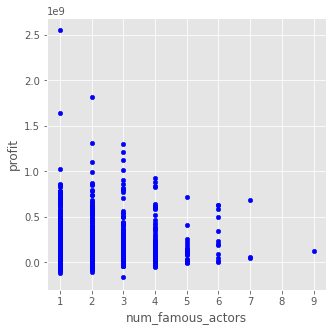

In [386]:
df_movie_revenue_budget_cast.plot(kind="scatter",  # Scatter Plot
          x="num_famous_actors",           # 'x' for x-axis
          y="profit",           # 'y' for y-axis
          figsize=(5,5),   # 5 x 5 size
          color="blue")    # blue dot

In [387]:
df_movie_revenue_budget_cast[df_movie_revenue_budget_cast["Action"] == 1].count()[0]

432

In [388]:
df_movie_revenue_budget_cast[df_movie_revenue_budget_cast["Adventure"] == 1].count()[0]

294

In [389]:
df_movie_revenue_budget_cast[df_movie_revenue_budget_cast["Romance"] == 1].count()[0]

628

In [390]:
df_movie_revenue_budget_cast[df_movie_revenue_budget_cast["Comedy"] == 1].count()[0]

930

In [391]:
df_movie_revenue_budget_cast[df_movie_revenue_budget_cast["Crime"] == 1].count()[0]

328

In [392]:
df_movie_revenue_budget_cast[df_movie_revenue_budget_cast["Horror"] == 1].count()[0]

118

In [393]:
df_movie_revenue_budget_cast[df_movie_revenue_budget_cast["Drama"] == 1].count()[0]

1353

In [394]:
df_movie_revenue_budget_cast[df_movie_revenue_budget_cast["Family"] == 1].count()[0]

286

In [395]:
df_movie_revenue_budget_cast[df_movie_revenue_budget_cast["Fantasy"] == 1].count()[0]

167

In [396]:
df_movie_revenue_budget_cast[df_movie_revenue_budget_cast["Mystery"] == 1].count()[0]

148

In [397]:
df_movie_revenue_budget_cast[df_movie_revenue_budget_cast["Science Fiction"] == 1].count()[0]

125

In [398]:
df_movie_revenue_budget_cast[df_movie_revenue_budget_cast["Thriller"] == 1].count()[0]

508

In [399]:
df_movie_revenue_budget_cast[df_movie_revenue_budget_cast["Western"] == 1].count()[0]

32

In [400]:
df_movie_revenue_budget_cast_Drama = df_movie_revenue_budget_cast[df_movie_revenue_budget_cast["Drama"] == 1]
df_movie_revenue_budget_cast_Drama

,budget,title,revenue,movie_id,Vision View Entertainment,The Cartel,TV Movie,Romance,Pulser Productions,Mardock Scramble Production Committee,...,Adventure,Western,Science Fiction,Sentai Filmworks,Odyssey Media,cast_name,cast_id,famous_actors,num_famous_actors,profit
40,7000000.0,Bottle Rocket,5.600690e+05,13685,0,0,0,1,0,0,...,0,0,0,0,0,"[Luke Wilson, Owen Wilson, Lumi Cavazos, Andre...","[36422, 887, 74940, 71555, 52797, 148593, 3085...",[Owen Wilson],1,-6439931.0
41,12000000.0,Happy Gilmore,4.120510e+07,9614,0,0,0,1,0,0,...,0,0,0,0,0,"[Adam Sandler, Ben Stiller, Christopher McDona...","[19292, 7399, 4443, 31171, 11794, 1101, 10460,...",[Ben Stiller],1,29205099.0
42,24000000.0,The Bridges of Madison County,1.820166e+08,688,0,0,0,1,0,0,...,0,0,0,0,0,"[Meryl Streep, Clint Eastwood, Annie Corley, V...","[5064, 190, 6907, 10379, 10380, 10381, 10382, ...","[Meryl Streep, Clint Eastwood]",2,158016617.0
43,72000000.0,Braveheart,2.100000e+08,197,0,0,0,1,0,0,...,0,0,0,0,0,"[Mel Gibson, Catherine McCormack, Sophie Marce...","[2461, 2462, 1957, 2463, 2464, 2039, 2465, 246...","[Brendan Gleeson, Brian Cox]",2,138000000.0
44,1300000.0,Taxi Driver,2.826257e+07,103,0,0,0,1,0,0,...,0,0,0,0,0,"[Robert De Niro, Cybill Shepherd, Harvey Keite...","[380, 1036, 1037, 1038, 1039, 1040, 13, 1041, ...",[Robert De Niro],1,26962574.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5320,250000000.0,The Fate of the Furious,1.238765e+09,337339,0,0,0,0,0,0,...,0,0,0,0,0,"[Vin Diesel, Jason Statham, Dwayne Johnson, Mi...","[12835, 976, 18918, 17647, 8169, 8171, 6885, 6...","[Jason Statham, Dwayne Johnson]",2,988764765.0
5322,175000000.0,Cars 3,3.501701e+08,260514,0,0,0,0,0,0,...,0,0,0,0,0,"[Owen Wilson, Cristela Alonzo, Chris Cooper, A...","[887, 1374727, 2955, 53807, 5149, 15897, 51797...",[Owen Wilson],1,175170057.0
5357,60000000.0,Rock Dog,9.420546e+06,333667,0,0,0,0,0,0,...,0,0,0,0,0,"[Luke Wilson, J.K. Simmons, Eddie Izzard, Lewi...","[36422, 18999, 1926, 59258, 16431, 2876, 52404...",[J.K. Simmons],1,-50579454.0
5380,260000000.0,Transformers: The Last Knight,6.049421e+08,335988,0,0,0,1,0,0,...,0,0,0,0,0,"[Mark Wahlberg, Josh Duhamel, Laura Haddock, A...","[13240, 19536, 209578, 4173, 2283, 1428070, 12...","[Mark Wahlberg, Stanley Tucci, John Turturro, ...",6,344942143.0


<AxesSubplot:xlabel='num_famous_actors', ylabel='profit'>

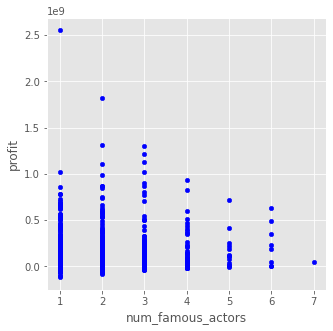

In [401]:
df_movie_revenue_budget_cast_Drama.plot(kind="scatter",  # Scatter Plot
          x="num_famous_actors",           # 'x' for x-axis
          y="profit",           # 'y' for y-axis
          figsize=(5,5),   # 5 x 5 size
          color="blue")    # blue dot

In [402]:
number_factors_total_profit = {}
number_factors_total_number = {}
for row in df_movie_revenue_budget_cast.iterrows():
    if row[1]['num_famous_actors'] in number_factors_total_profit:
        number_factors_total_profit[row[1]['num_famous_actors']] += row[1]['profit']
        number_factors_total_number[row[1]['num_famous_actors']] += 1
    else:
        number_factors_total_profit[row[1]['num_famous_actors']] = row[1]['profit']
        number_factors_total_number[row[1]['num_famous_actors']] = 1

In [403]:
number_factors_mean_profit = []
number_factors = []
for key in number_factors_total_profit:
    number_factors.append(key)
    number_factors_mean_profit.append(number_factors_total_profit[key]/number_factors_total_number[key])

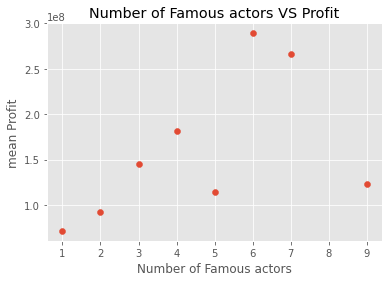

In [404]:
plt.scatter(number_factors, number_factors_mean_profit)
plt.title('Number of Famous actors VS Profit')
plt.xlabel('Number of Famous actors')
plt.ylabel('mean Profit')
plt.show()

In [405]:
X = list(df_movie_revenue_budget_cast['num_famous_actors'])
y = list(df_movie_revenue_budget_cast['profit'])
d = {y[i]:X[i] for i in range(len(X))}
sorted_d = sorted(d.items(), key = lambda x: x[1])
X = []
y = []
for p in sorted_d:
    X.append(p[1])
    y.append(p[0])
X = np.array(X).reshape(-1,1)

In [406]:
#fitting the polynomial regression model to the dataset
poly_reg=PolynomialFeatures(degree=10)
X_poly=poly_reg.fit_transform(X)
poly_reg.fit(X_poly,y)
lin_reg2=LinearRegression()
lin_reg2.fit(X_poly,y)

LinearRegression()

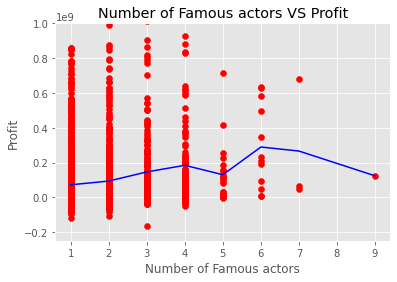

In [407]:
#Visualising the pollynomial regression model results
X_grid=np.arange(min(X),max(X),0.1)
X_grid=X_grid.reshape((len(X_grid),1))
plt.scatter(X,y,color='red')
plt.plot(X,lin_reg2.predict(poly_reg.fit_transform(X)),color='blue')
plt.title('Number of Famous actors VS Profit')
plt.xlabel('Number of Famous actors')
plt.ylabel('Profit')
plt.ylim([-0.25*10**9, 10**9])
plt.show()

### 3. Conclusion

From the images after data analysis, we can see that from one famous actor to four famous actors, the movie profits are steadily rising. Films with five famous actors were bottlenecked, but films with six famous actors were the most profitable.